In [1]:
### Imports (TODO remove this when finished)
%load_ext autoreload
%autoreload 2

# Append root folder in case you haven't installed NIDN
import sys
sys.path.append("../..")

import nidn
import torch
nidn.set_log_level("INFO")

10:03:44|NIDN-INFO| Initialized NIDN for cpu
10:03:44|NIDN-INFO| Using double precision
10:03:44|NIDN-INFO| Switching log level to warning.


# Single layer , uniform, regression

In [14]:
# Settings, smaller spectrum and coarser simulation to speed up inference
# (This also leads to some warnings below, not to worry)
cfg = nidn.load_default_cfg()
cfg.N_freq = 16
cfg.N_layers = 1
cfg.PER_LAYER_THICKNESS=[0.38]
cfg.physical_wavelength_range[0]=3e-7
cfg.physical_wavelength_range[1]=9e-7
cfg.solver = "FDTD"
cfg.FDTD_min_gridpoints_per_unit_magnitude = 32
cfg.FDTD_niter = int(800 *  cfg.FDTD_min_gridpoints_per_unit_magnitude / 50)
cfg.FDTD_pulse_type = 'continuous'
cfg.FDTD_source_type = 'line'
cfg.target_frequencies = nidn.compute_target_frequencies(
    cfg.physical_wavelength_range[0],
    cfg.physical_wavelength_range[1],
    cfg.N_freq,
    cfg.freq_distribution
)

10:31:49|NIDN-WARNING| Due to the grid resolution, the thickness of layer 1 is set to 0.390 µminstead of the specified 0.38 µm
10:31:55|NIDN-INFO| The sum of the transmission and reflection coefficient is marginally greater than 1 (1.0008), which is physically impossible. Normalizing to 1.
10:31:57|NIDN-INFO| The sum of the transmission and reflection coefficient is marginally greater than 1 (1.0058), which is physically impossible. Normalizing to 1.
10:32:05|NIDN-INFO| The sum of the transmission and reflection coefficient is marginally greater than 1 (1.0061), which is physically impossible. Normalizing to 1.
10:32:10|NIDN-INFO| The sum of the transmission and reflection coefficient is marginally greater than 1 (1.0013), which is physically impossible. Normalizing to 1.
10:32:13|NIDN-WARNING| The sum of the transmission and reflection coefficient is greater than 1 (1.0318), which is physically impossible. Normalizing to 1.
10:32:18|NIDN-INFO| The sum of the transmission and reflectio

Physical wavelengths are (in meters):
[9.00000000e-07 7.94117647e-07 7.10526316e-07 6.42857143e-07
 5.86956522e-07 5.40000000e-07 5.00000000e-07 4.65517241e-07
 4.35483871e-07 4.09090909e-07 3.85714286e-07 3.64864865e-07
 3.46153846e-07 3.29268293e-07 3.13953488e-07 3.00000000e-07]


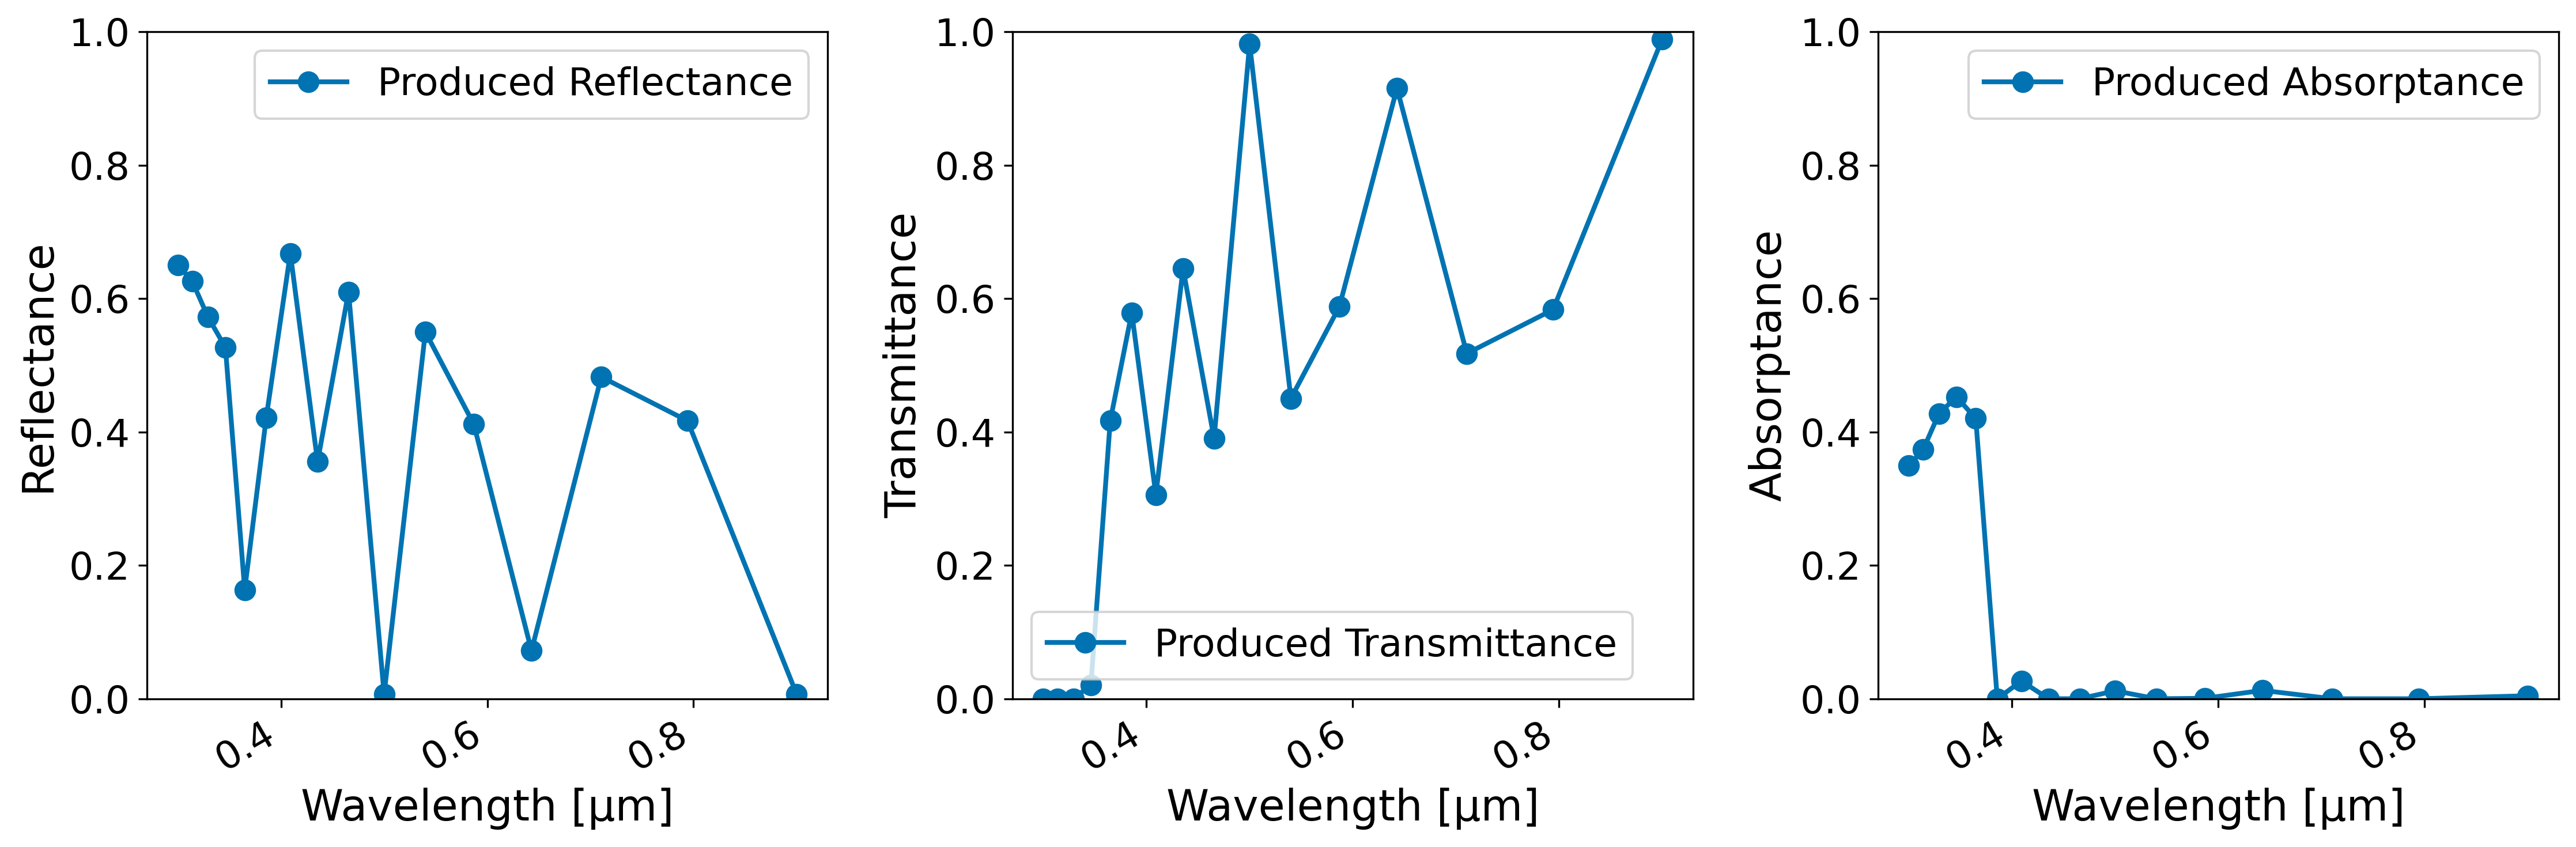

In [15]:
# Compute ground truth
eps_grid = torch.zeros(cfg.Nx,cfg.Ny,cfg.N_layers,cfg.N_freq,dtype=torch.cfloat)
layer_builder = nidn.LayerBuilder(cfg)
eps_grid[:,:,0,:] = layer_builder.build_uniform_layer("titanium_oxide")
# Compute spectrum for this configuration
R,T = nidn.compute_spectrum(eps_grid,cfg)
nidn.plot_spectrum(cfg,R,T,show_absorption=True)

cfg.target_reflectance_spectrum = R
cfg.target_transmittance_spectrum = T

physical_wls, normalized_freqs = nidn.get_frequency_points(cfg)
print("Physical wavelengths are (in meters):")
print(physical_wls)

In [16]:
cfg.pop("model",None); # Forget the old model

# Allowed range of epsilon values
cfg.real_min_eps = 0.00
cfg.real_max_eps = 20.0
cfg.imag_min_eps = 0.0
cfg.imag_max_eps = 6.0

cfg.type = "regression" # Choose type as described above

In [17]:
nidn.print_cfg(cfg)

name                   : example_name   |use_gpu                : 0              |seed                   : 100            |
model_type             : siren          |iterations             : 3000           |learning_rate          : 8e-05          |
type                   : regression     |reg_loss_weight        : 0.05           |use_regularization_loss: 1              |
L                      : 1.0            |absorption_loss        : 0              |n_neurons              : 100            |
hidden_layers          : 9              |encoding_dim           : 4              |siren_omega            : 1.0            |
add_noise              : 0              |noise_scale            : 0.001          |eps_oversampling       : 1              |
real_min_eps           : 0.0            |real_max_eps           : 20.0           |imag_min_eps           : 0.0            |
imag_max_eps           : 6.0            |solver                 : FDTD           |Nx                     : 1              |
Ny      

In [18]:
cfg.iterations = 200 # Set number of training iterations (that is forward model evaluations) to perform
nidn.run_training(cfg);

10:33:55|NIDN-WARNING| Due to the grid resolution, the thickness of layer 1 is set to 0.390 µminstead of the specified 0.38 µm
10:34:51|NIDN-INFO| ###  New Best=0.3044 with SpectrumLoss=0.3044 ### L1=0.3044
10:34:51|NIDN-INFO| It=0     Loss=0.3044   |  weighted_avg=0.3044  |  SpectrumLoss=0.3044 | L1=0.3044
10:38:54|NIDN-INFO| ###  New Best=0.3006 with SpectrumLoss=0.3006 ### L1=0.3006
10:40:57|NIDN-INFO| ###  New Best=0.2950 with SpectrumLoss=0.2950 ### L1=0.2950
10:42:50|NIDN-INFO| ###  New Best=0.2902 with SpectrumLoss=0.2902 ### L1=0.2902
10:44:45|NIDN-INFO| ###  New Best=0.2802 with SpectrumLoss=0.2802 ### L1=0.2802
10:44:45|NIDN-INFO| It=5     Loss=0.2802   |  weighted_avg=0.2972  |  SpectrumLoss=0.2802 | L1=0.2802
10:46:41|NIDN-INFO| ###  New Best=0.2662 with SpectrumLoss=0.2662 ### L1=0.2662
10:48:39|NIDN-INFO| ###  New Best=0.2624 with SpectrumLoss=0.2624 ### L1=0.2624
10:50:40|NIDN-INFO| ###  New Best=0.2494 with SpectrumLoss=0.2494 ### L1=0.2494
10:54:47|NIDN-INFO| ###  New 

17:23:29|NIDN-WARNING| Due to the grid resolution, the thickness of layer 1 is set to 0.390 µminstead of the specified 0.38 µm


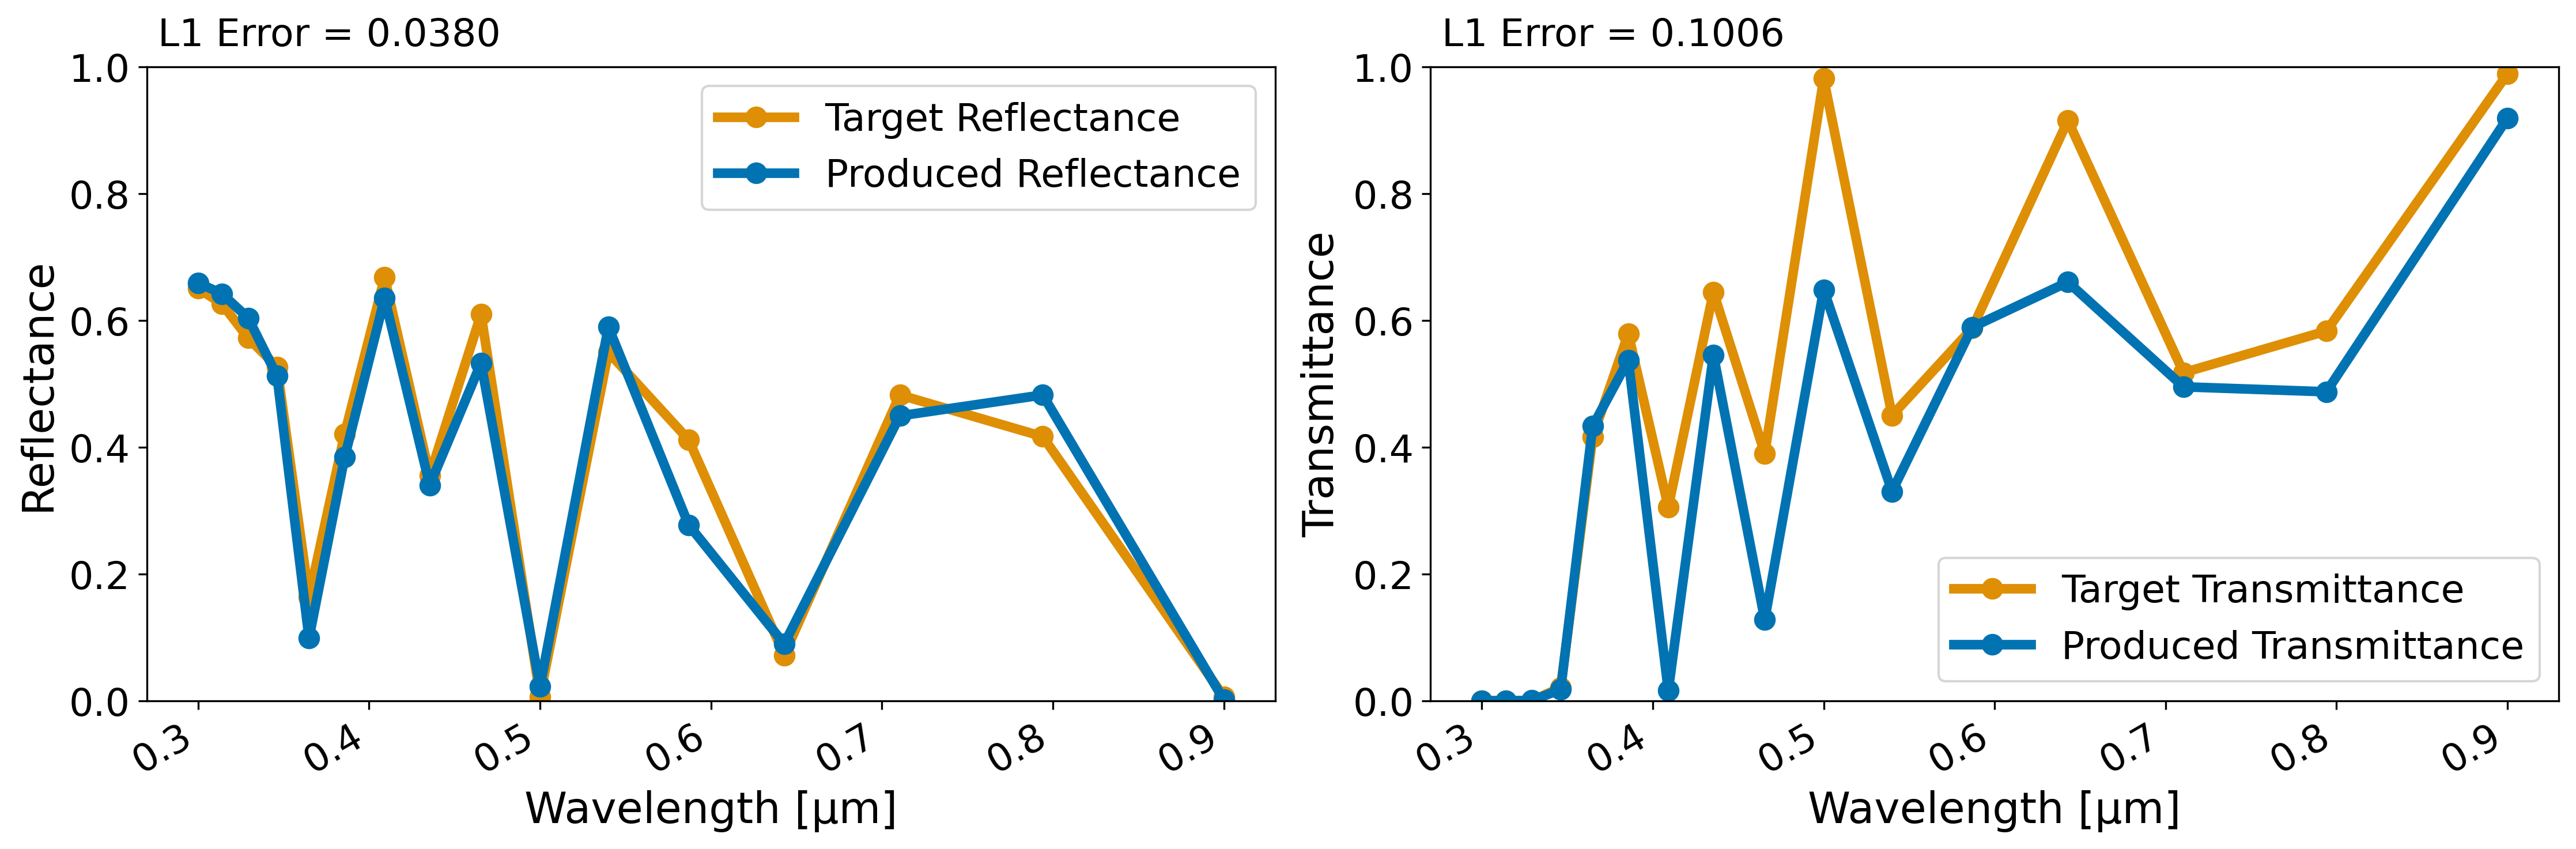

In [19]:
nidn.plot_spectra(cfg)

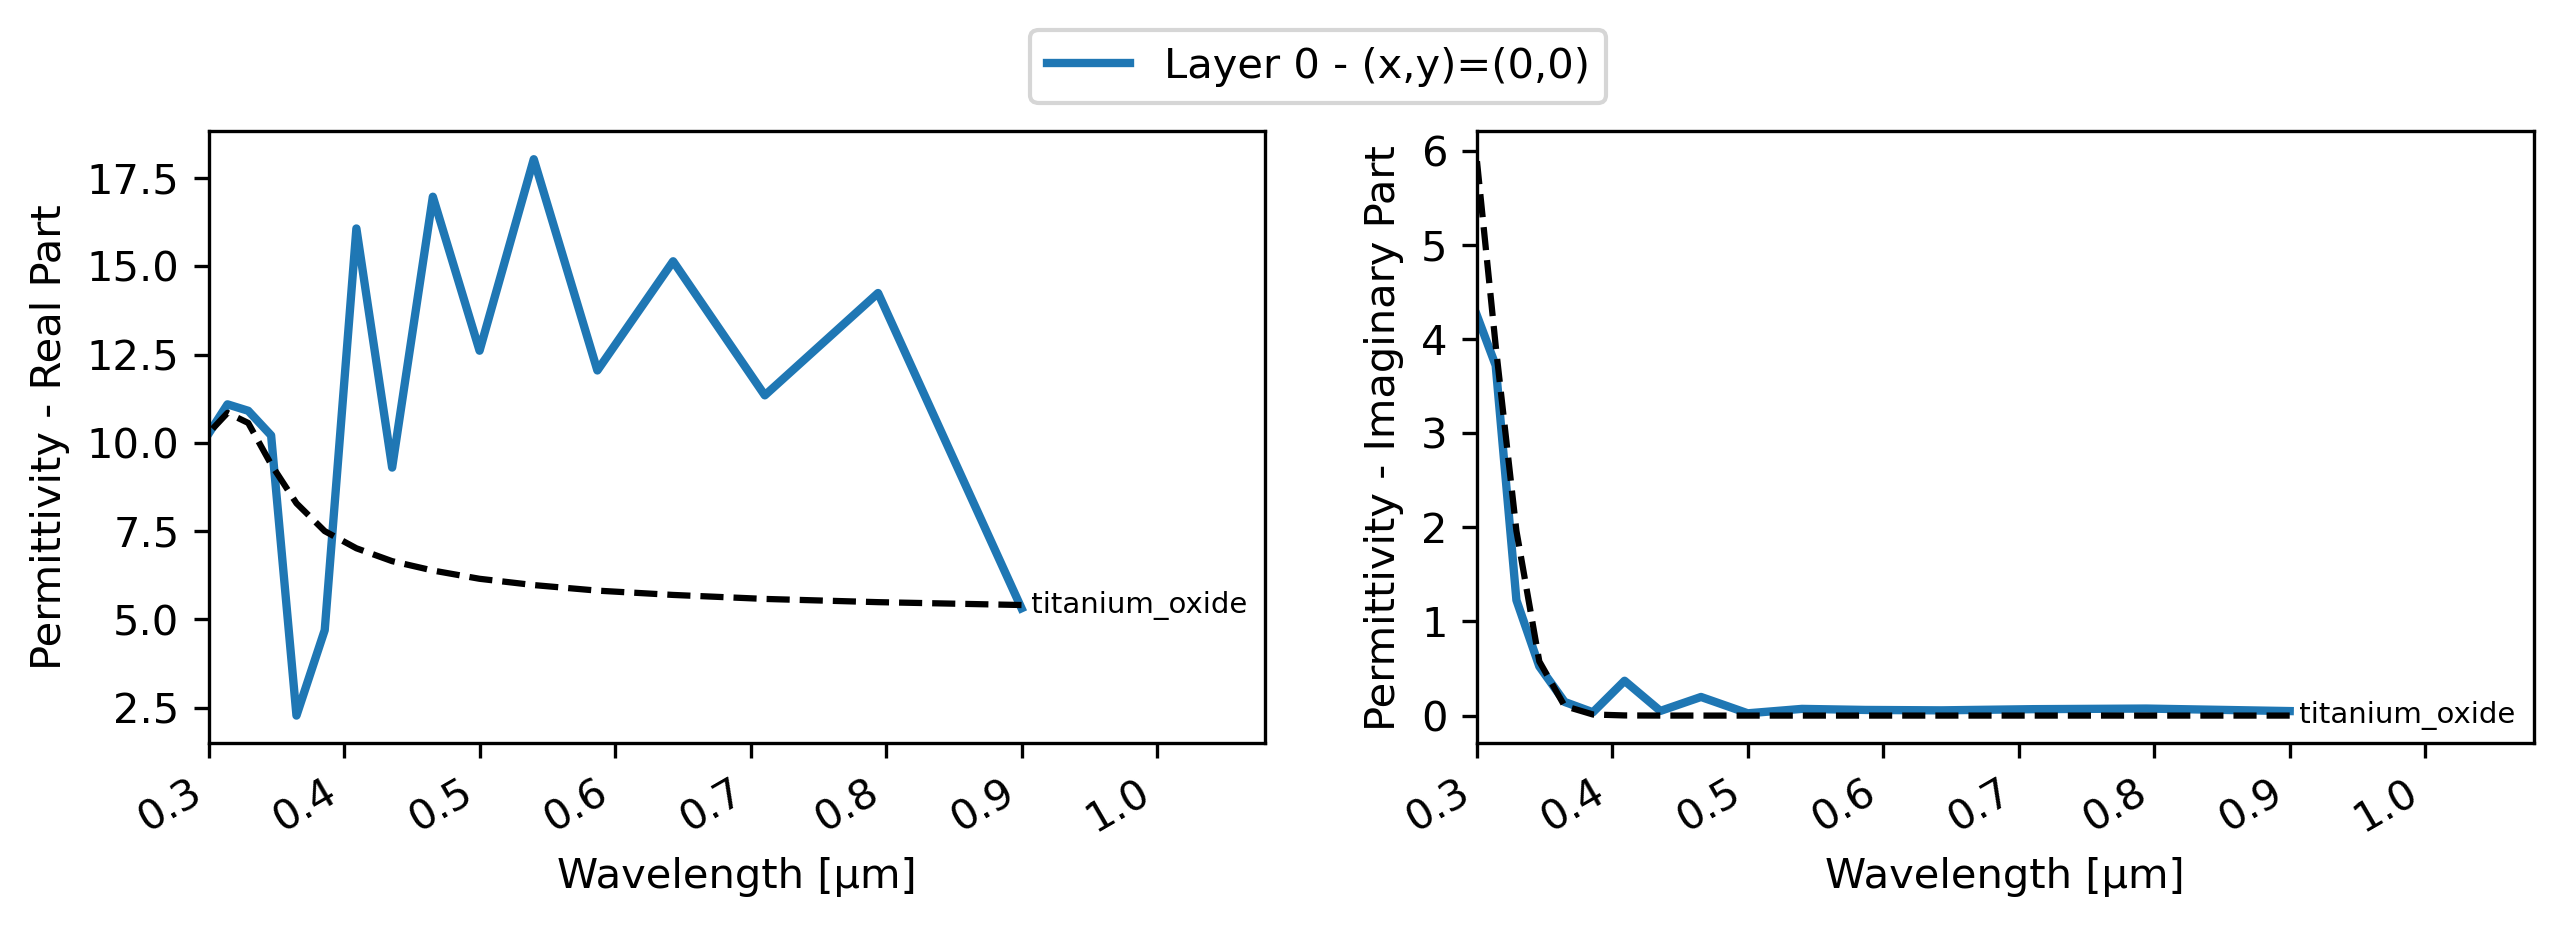

In [20]:
nidn.plot_eps_per_point(cfg,compare_to_material="titanium_oxide")

In [21]:
cfg.name = "1layer_fdtd_reg"
nidn.save_run(cfg)

17:25:51|NIDN-INFO| Saving run to file: ../results//1layer_fdtd_reg_30-07-2022 17-25-51_run.pk


# Single layer , uniform, classification

In [24]:
cfg.pop("model",None); # Forget the old model

# Allowed range of epsilon values
cfg.real_min_eps = 0.0
cfg.real_max_eps = 20.0
cfg.imag_min_eps = 0.0
cfg.imag_max_eps = 6.0

cfg.type = "classification" # Choose type as described above
cfg.iterations = 50 # Set number of training iterations (that is forward model evaluations) to perform

In [25]:
nidn.run_training(cfg);

18:27:27|NIDN-WARNING| Due to the grid resolution, the thickness of layer 1 is set to 0.390 µminstead of the specified 0.38 µm
18:29:55|NIDN-WARNING| There are not enough timesteps for the transmission signal to have the proper length / or no signal is transmited. The signal should at least contain 2 peaks, but 0 is found.The FDTD_niter should be increased, to be sure that the resutls are valid.
18:30:08|NIDN-WARNING| There are not enough timesteps for the transmission signal to have the proper length / or no signal is transmited. The signal should at least contain 2 peaks, but 0 is found.The FDTD_niter should be increased, to be sure that the resutls are valid.
18:30:08|NIDN-INFO| ###  New Best=0.3129 with SpectrumLoss=0.3079 ### L1=0.3079
18:30:08|NIDN-INFO| It=0     Loss=0.3129   |  weighted_avg=0.3129  |  SpectrumLoss=0.3079 | L1=0.3079
18:33:36|NIDN-INFO| ###  New Best=0.2905 with SpectrumLoss=0.2869 ### L1=0.2869
18:35:25|NIDN-INFO| ###  New Best=0.2474 with SpectrumLoss=0.2450 #

20:58:00|NIDN-WARNING| Due to the grid resolution, the thickness of layer 1 is set to 0.390 µminstead of the specified 0.38 µm
20:58:07|NIDN-INFO| The sum of the transmission and reflection coefficient is marginally greater than 1 (1.0002), which is physically impossible. Normalizing to 1.
20:58:10|NIDN-INFO| The sum of the transmission and reflection coefficient is marginally greater than 1 (1.0050), which is physically impossible. Normalizing to 1.
20:58:20|NIDN-INFO| The sum of the transmission and reflection coefficient is marginally greater than 1 (1.0045), which is physically impossible. Normalizing to 1.
20:58:30|NIDN-WARNING| The sum of the transmission and reflection coefficient is greater than 1 (1.0253), which is physically impossible. Normalizing to 1.
20:58:55|NIDN-WARNING| There are not enough timesteps for the transmission signal to have the proper length / or no signal is transmited. The signal should at least contain 2 peaks, but 0 is found.The FDTD_niter should be inc

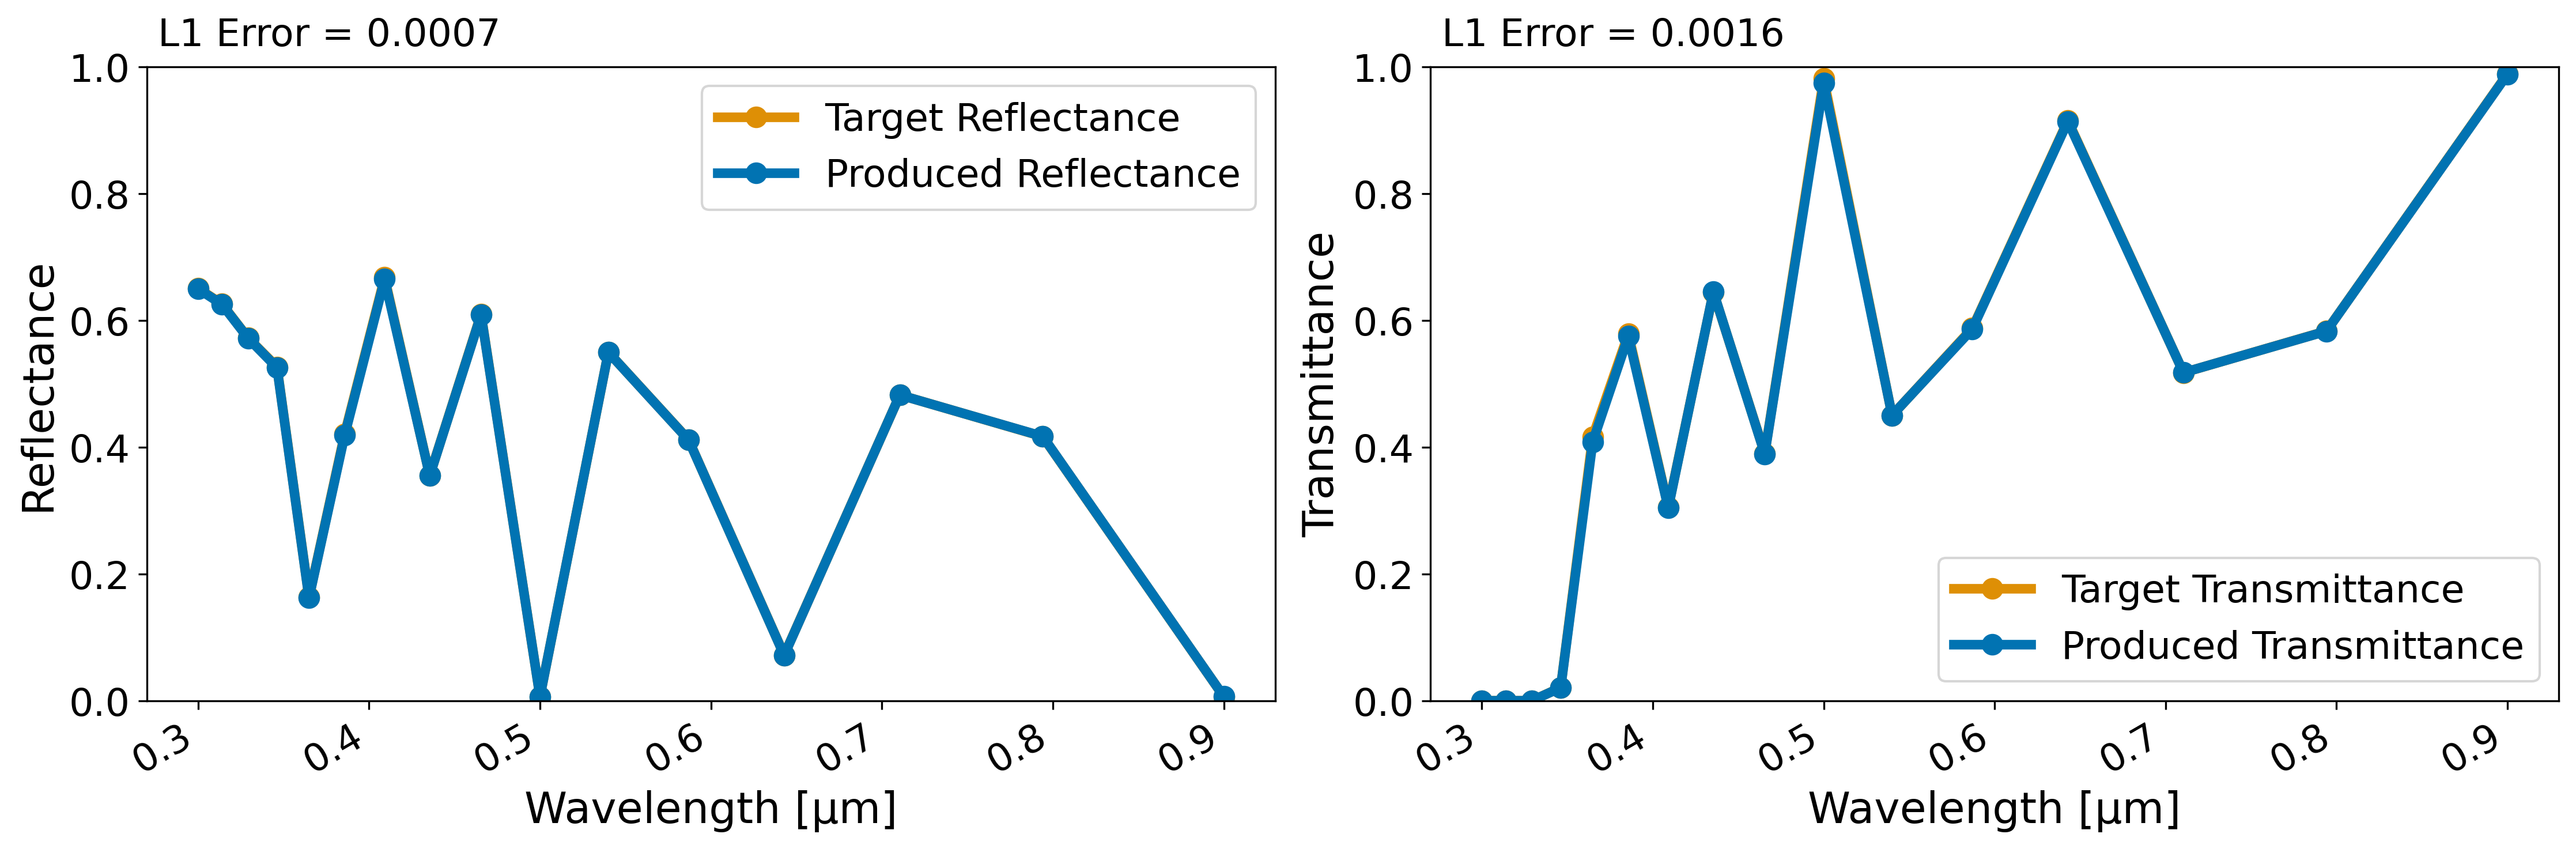

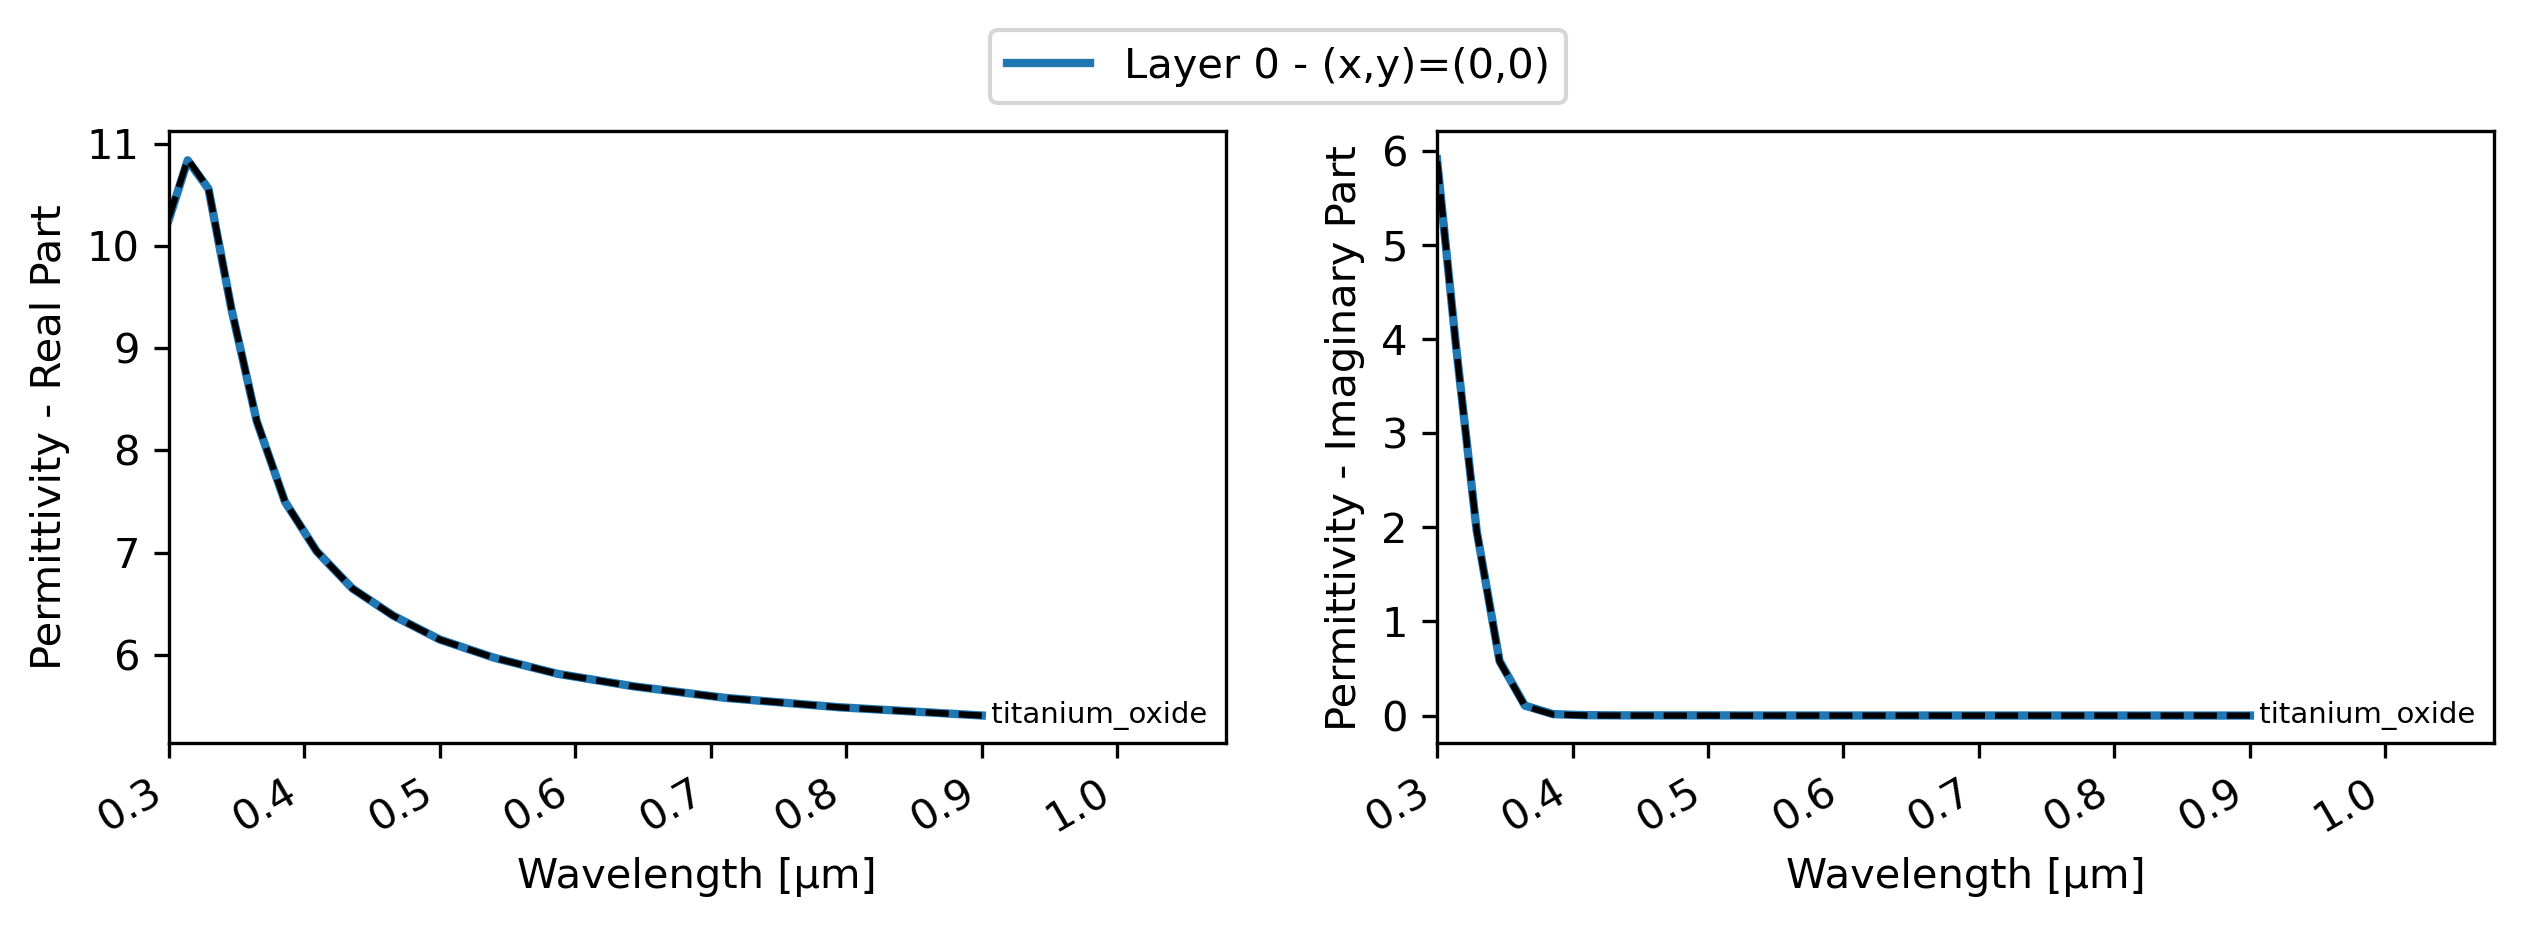

In [26]:
nidn.plot_spectra(cfg)
nidn.plot_eps_per_point(cfg)

In [27]:
cfg.name = "1layer_fdtd_class"
nidn.save_run(cfg)

20:59:56|NIDN-INFO| Saving run to file: ../results//1layer_fdtd_class_30-07-2022 20-59-56_run.pk


## Uniform Three-Layer Ground Truth 

In [ ]:
# Load default cfg as starting point
cfg = nidn.load_default_cfg()

# Set grid specifics
cfg.Nx = 1
cfg.Ny = 1
cfg.N_layers = 3
cfg.N_freq = 16
cfg.PER_LAYER_THICKNESS = [0.1]
cfg.FDTD_pulse_type = 'continuous'
cfg.FDTD_source_type = 'line'

# Specify your desired range of wavelengths
cfg.physical_wavelength_range[0] = 8e-7 
cfg.physical_wavelength_range[1] = 1.5e-6

cfg.target_reflectance_spectrum = [0.41897427,0.39591158,0.41332836,0.44050670,0.47452302,0.50973356,0.52690292,0.53404939,0.51684631,0.40007779,0.40960854,0.54935004,0.50675232,0.67787965,0.66292254,0.79244483,]
cfg.target_transmittance_spectrum = [0.57266058,0.59123892,0.57286972,0.54174457,0.50317150,0.46341936,0.42688453,0.38601254,0.30563326,0.26237625,0.15404439,0.08091528,0.06232964,0.03206342,0.02864806,0.01709644,]

cfg.FDTD_niter = 500
cfg.solver ="FDTD"

nidn.plot_spectrum(cfg,
                   cfg.target_reflectance_spectrum,
                   cfg.target_transmittance_spectrum)

In [ ]:
# Allowed range of epsilon values
cfg.pop("model",None); # Forget the old model
cfg.real_min_eps = 0.1
cfg.real_max_eps = 20.0
cfg.imag_min_eps = 0.0
cfg.imag_max_eps = 20.0

cfg.type = "regression" # Choose type as described above (for now still regression)
cfg.iterations = 100 # Set number of training iterations (that is forward model evaluations) to perform

In [ ]:
nidn.run_training(cfg);

In [ ]:
nidn.plot_eps_per_point(cfg,compare_to_material=["titanium_oxide","germanium","tantalum_pentoxide"])

In [ ]:
# The other plots
nidn.plot_spectra(cfg)

In [ ]:
cfg.name = "3layer_fdtd_reg"
nidn.save_run(cfg)

In [ ]:
# Allowed range of epsilon values
cfg.pop("model",None); # Forget the old model

cfg.type = "classification" # Choose type as described above (for now still regression)
cfg.iterations = 100 # Set number of training iterations (that is forward model evaluations) to perform

In [ ]:
nidn.run_training(cfg);

In [ ]:
nidn.plot_eps_per_point(cfg,compare_to_material=["titanium_oxide","germanium","tantalum_pentoxide"])

In [ ]:
nidn.plot_spectra(cfg)

In [ ]:
cfg.name = "3layer_fdtd_class"
nidn.save_run(cfg)